https://gwpy.github.io/docs/stable/examples/timeseries/qscan.html


https://gwpy.github.io/docs/stable/examples/timeseries/pycbc-snr.html


https://gwpy.github.io/docs/stable/examples/timeseries/inject.html


https://gwpy.github.io/docs/stable/examples/signal/gw150914.html


https://gwpy.github.io/docs/stable/examples/spectrogram/plot.html

#install

In [1]:
pip install gwpy h5py astropy gwosc lalsuite Pillow Pycbc

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 30.3MB 75kB/s 
     |████████████████████████████████| 3.1MB 32.2MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 1.6MB 39.4MB/s 
     |████████████████████████████████| 471kB 52.0MB/s 
     |████████████████████████████████| 798kB 45.5MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 2.3MB 41.6MB/s 
  Created wheel for Pycbc: filename=PyCBC-1.15.2-cp36-cp36m-linux_x86_64.whl size=5592947 sha256=03960ed037b871c780e5d9b1a447f6055bca5d894633aeb722694b8017ff1e4d
  Stored in directory: /root/.cache/pip/wheels/05/76/01/fc533a502b9beafe9f8a70d83df4c5eb8949d86ee3a41ff759
  Created wheel for ligo-segments: filename=ligo_segments-1.2.0-cp36-cp36m-linux_x86_64.whl size=83624 sha256=9cbcdf34ef691ad83254edb8093f7905d560951c7a3f93422f15f9541898e3af
  Stored in directory: /root/.cache/pip/wheels/5d/1e/4a/ab

#declare libraries

In [0]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.image as mpimg
import matplotlib as mlp

import numpy as np

from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design
from gwpy.segments import DataQualityFlag
from gwpy.plot import Plot
from gwpy.segments import Segment

#plot straindata

In [0]:
def p(qty):
  plot = Plot(figsize=[15, 4])
  ax = plot.gca()
  ax.plot(qty)
  ax.set_ylim(-1e-21, 1e-21)
  plt.show()
  #fig = plt.figure()
  #print(fig.get_size_inches()*fig.dpi) # size in pixels
  return plot

#plot detection 

In [0]:
def plot_detect(lfilt,hfilt,time_l,time_u):
  plot = Plot(figsize=[12, 4])
  ax = plot.gca()
  ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
  ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
  ax.set_xlim(time_l, time_u)
  ax.set_xscale('seconds', epoch=time_l)
  #ax.set_ylabel('Amplitude [strain]')
  ax.set_ylim(-1e-12, 1e-12)
  ax.legend()
  plt.show()

## SNR signal to noise ratio:

it is the ratio of power of signal to the noise

In [0]:
#The example Filtering a TimeSeries to detect gravitational waves showed us we can visually extract a signal from the noise using basic signal-processing techniques.
#However, an actual astrophysical search algorithm detects signals by calculating the signal-to-noise ratio (SNR) of data for each in a large bank of signal models, known as templates.
#Using pycbc (the actual search code), we can do that.
#First, as always, we fetch some of the public data from the LIGO Open Science Center:

from gwpy.timeseries import TimeSeries
data = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)
#and condition it by applying a highpass filter at 15 Hz

high = data.highpass(15)
#This is important to remove noise at lower frequencies that isn’t accurately calibrated, and swamps smaller noises at higher frequencies.
#For this example, we want to calculate the SNR over a 4 second segment, so we calculate a Power Spectral Density with a 4 second FFT length (using all of the data), then crop() the data:

psd = high.psd(4, 2)
zoom = high.crop(1126259460, 1126259464)
#In order to calculate signal-to-noise ratio, we need a signal model against which to compare our data. For this we import pycbc.waveform.get_fd_waveform and generate a template as a pycbc.types.FrequencySeries:

from pycbc.waveform import get_fd_waveform
hp = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,f_lower=20, f_final=2048, delta_f=psd.df.value)
#At this point we are ready to calculate the SNR, so we import the pycbc.filter.matched_filter method, and pass it our template, the data, and the PSD:

from pycbc.filter import matched_filter
snr = matched_filter(hp, zoom.to_pycbc(), psd=psd.to_pycbc(),low_frequency_cutoff=15)
snrts = TimeSeries.from_pycbc(snr).abs()
#Note
#Here we have used the to_pycbc() methods of the TimeSeries and FrequencySeries objects to convert from GWpy objects to something that PyCBC functions can understand, and then used the from_pycbc() method to convert back to a GWpy object.
#We can plot the SNR TimeSeries around the region of interest:

plot = snrts.plot()
ax = plot.gca()
ax.set_xlim(1126259461, 1126259463)
ax.set_epoch(1126259462.427)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation for GW150914')
plot.show()
#We can clearly see a large spike (above 17!) at the time of the GW150914 signal! This is, in principle, how the full, blind, CBC search is performed, using all of the available data, and a bank of tens of thousand of signal models.

#Hanford data for time delay

In [0]:
def time_delay(tl_l,tl_u,lfilt):
    
##________________________________________________HANFORD DATA_____________________________________________________
  
  data_set_H = TimeSeries.fetch_open_data('H1', tl_l,tl_u)
  bp = filter_design.bandpass(50, 250, data_set_H.sample_rate)
  notches = [filter_design.notch(line, data_set_H.sample_rate) for line in (60, 120, 180)]
  hfilt = data_set_H.filter(zpk, filtfilt=True)
  hfilt = hfilt.crop(*hfilt.span.contract(1)) 
  
  lfilt.shift('6.9ms')
  lfilt *= -1
  
  p(hfilt,"gwpy:ligo-hanford")
  ax = plot.gca()
  ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
  ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
  ax.set_xlim(tl_l, tl_u)
  #ax.set_ylabel('Amplitude [strain]')
  ax.set_ylim(-1e-12, 1e-12)
  ax.legend()
  plt.show()

#setting timelines

In [6]:
timeline_set=np.arange(1167556608,1167560704,.5)#1135132672,1135136768
print(len(timeline_set))

8192


In [0]:
1167556608,1167560704

#checking timelines

## plotting data quality

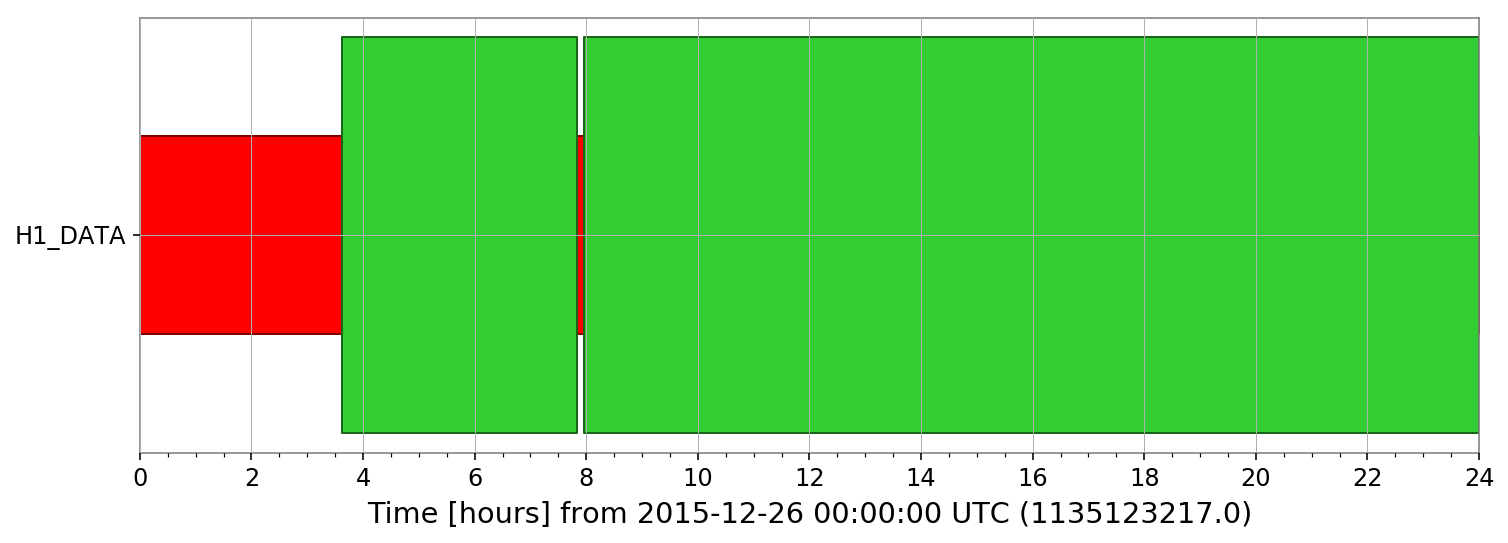

In [0]:
from gwpy.segments import DataQualityFlag
segments= DataQualityFlag.fetch_open_data('H1_DATA','December 26 2015','December 27 2015')
plot=segments.plot()

## waveform of the data

Livingston data


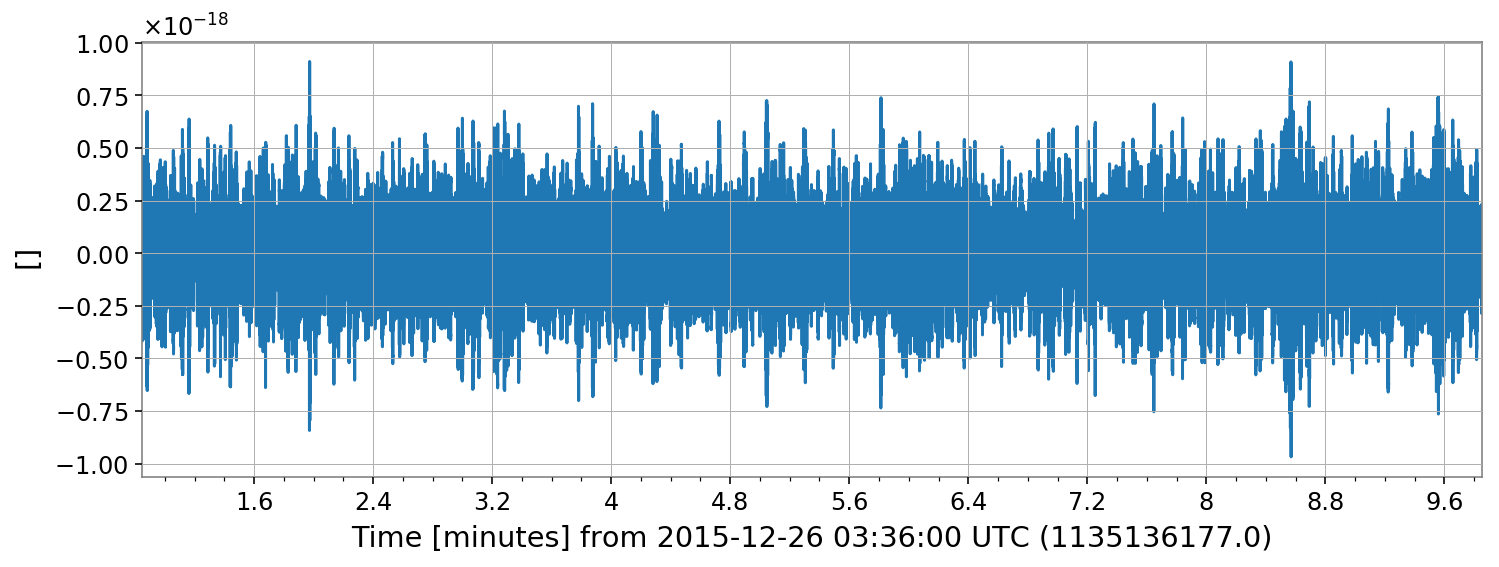

In [0]:
data_check_L=TimeSeries.fetch_open_data('H1',1135132672,1135136768)
print("Livingston data")
plot=data_check_L.plot()
plt.show()

## passing the CAT and DATA tests

Fetched 1 URLs from www.gw-osc.org for [1187008782 .. 1187008982))
Reading data... [Done]


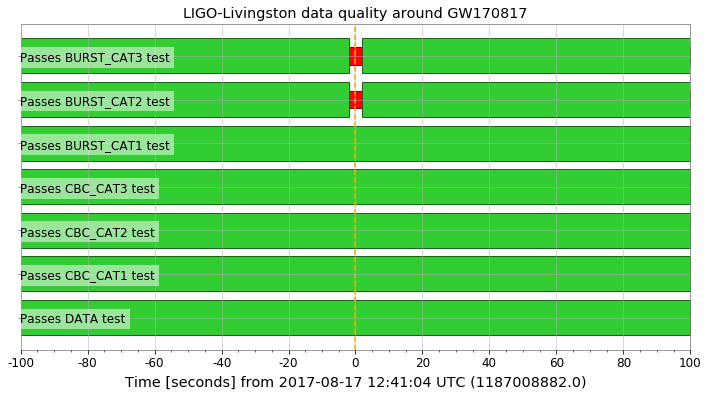

In [0]:
from gwpy.timeseries import StateVector
data = StateVector.fetch_open_data('L1', 1187008882-100, 1187008882+100,
                                   verbose=True, tag='C00')
plot = data.plot(insetlabels=True)
ax = plot.gca()
ax.set_xscale('seconds', epoch=1187008882)
ax.axvline(1187008882, color='orange', linestyle='--')
ax.set_title('LIGO-Livingston data quality around GW170817')
plot.show()

#learning algorithm

In [0]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms

def learn_algo(data):
  data=torchvision.transforms.Compose([transforms.ToTensor()])
  train_loader=torch.utils.data.DataLoader(data,batch_size=1)

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('My Drive/data for GW/1.png')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

# acessing dir

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

KeyboardInterrupt: ignored

In [0]:
ls 'gdrive/My Drive/GW data'

#printing and saving the strain data

In [0]:
na=[str(a) for a in np.arange(0,8199,1)]

data=np.zeros(len(timeline_set)-1)

for i in range(len(timeline_set)):
  data_set_H=TimeSeries.fetch_open_data('H1',timeline_set[i],timeline_set[i+2])
  
  # bandpass filter
  bp = filter_design.bandpass(50, 250, data_set_H.sample_rate)
  
  #notch filter :These filters reject/attenuate signals in a specific frequency band called the stop band frequency range and pass the signals above and below this band
  notches = [filter_design.notch(line, data_set_H.sample_rate) for line in (60, 120,180)]

  zpk = filter_design.concatenate_zpks(bp, *notches)
  lfilt = data_set_H.filter(zpk, filtfilt=True)
  ldata = data_set_H.crop(*data_set_H.span.contract(1))
  lfilt = lfilt.crop(*lfilt.span.contract(1)) 
  a=p(lfilt)
  print(timeline_set[i],'  ',timeline_set[i+2])
  loc='gdrive/My Drive/GW data/'+na[i]+'.png'
  a.savefig(loc, dpi=600)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import PIL
from numpy import asarray
from PIL import Image
from matplotlib import pyplot

In [0]:
#load_image='My Drive/data for GW/'+na[i]+'.png'
#at = image.imread(load_image)

#a=learn_algo(dat)
  
if (0):

    time_delay(timeline_set[i],timeline_set[i+1],lfilt)
    lfilt.shift(t_delay)
     #______________________________________________QTRANSFORM___________________________________________________________
    search=search = Segment(timeline_set[i]-0.25, timeline_set[i]+0.25)
    qgram = data_set_L.q_gram(qrange=(4, 150), search=search, mismatch=0.35)
    plot_Qtransform(qgram,timeline_set[i])

# PREDICTING THE NEW GW

In [0]:
import PIL
from numpy import asarray
from PIL import Image
from matplotlib import pyplot
# load image
na=[str(a) for a in range(64100)]
data=np.zeros((234,410,2600), dtype=np.float32)
for i in np.arange(233):
  loc='/content/gdrive/My Drive/GW DATA/'+na[i]+'.png'
  image = Image.open(loc)
  # create a cropped image
  cropped = image.crop((550, 390, 3150, 800))
  gs_image = cropped.convert(mode='L')
  k=asarray(gs_image)
  data[i]=k
  #print(k,np.min(k),np.max(k))
  #print(k.shape,k.size)
  pyplot.imshow(k)
  pyplot.show()

In [0]:
print(data.shape)

(234, 410, 2600)


In [0]:
data=torch.Tensor(data)
print(type(data))

<class 'torch.Tensor'>


In [0]:
train_loader=torch.utils.data.DataLoader(data,batch_size=5)

In [0]:
data.train_labels

In [0]:
from gwpy.timeseries import TimeSeries
data = TimeSeries.fetch_open_data('H1',1167558608,1167560000)

In [0]:
high = data.highpass(15)

In [0]:
psd = high.psd(4, 2)
zoom = high.crop(1167559934,1167559938)

In [0]:
from pycbc.waveform import get_fd_waveform
hp, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32,
                        f_lower=20, f_final=2048, delta_f=psd.df.value)

In [0]:
from pycbc.filter import matched_filter
snr = matched_filter(hp, zoom.to_pycbc(), psd=psd.to_pycbc(),
                     low_frequency_cutoff=15)
snrts = TimeSeries.from_pycbc(snr).abs()

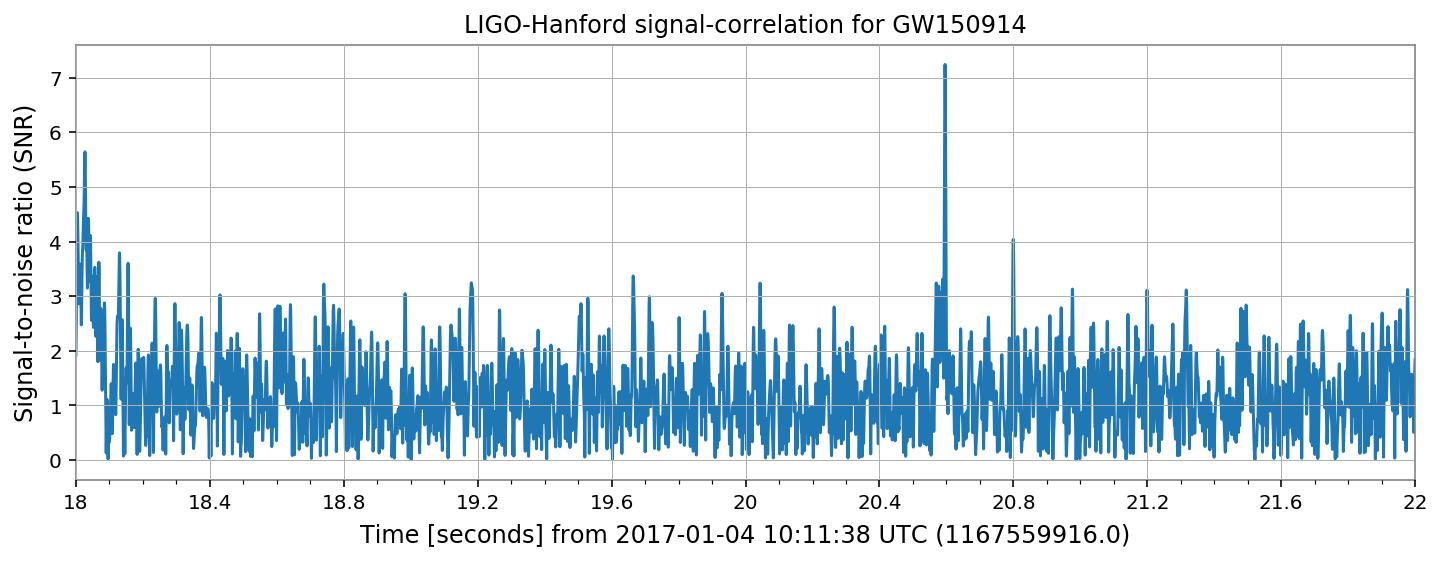

In [0]:
plot = snrts.plot()
ax = plot.gca()
ax.set_xlim(1167559934,1167559938)
ax.set_epoch(1167559916)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation for GW150914')
plot.show()

In [0]:
%matplotlib inline

# Read in the data around GW150914 //GW170104
from pycbc.catalog import Merger
import pylab

m = Merger('GW151226')
print(m)
data = {}

for i in ['L1','H1']:#, 'L1']:
    data[i] = m.strain(i)
    print(i)

L1
H1


131072


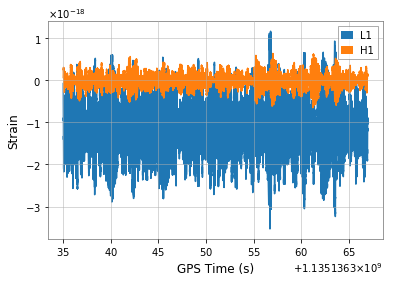

In [0]:
print(len(data[i].sample_times))
for i in data:
    pylab.plot(data[i].sample_times, data[i], label=i)#1167559934,1167559938

pylab.ylabel('Strain')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()

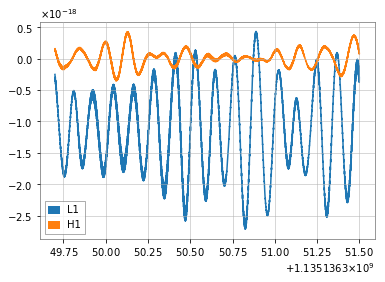

In [0]:
for ifo in data:
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = data[ifo].time_slice(m.time - 0.9, m.time + 0.9)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()

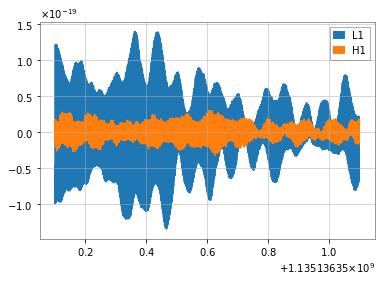

In [0]:
for ifo in data:
    # Apply a highpass filter to the data. This suppresses the low
    # frequency content of the data. We choose here a finite-impulse-response (FIR).
    # Options
    # 1) highpass frequency
    # 2) half sample length of highpass filter 
    #(higher value will give less ripple in passband)
    high_data = data[ifo].highpass_fir(15, 512) # Highpass point is 15 Hz
    
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = high_data.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()

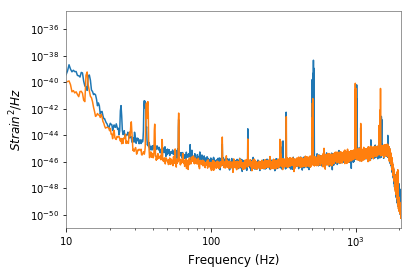

In [0]:
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd)
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(10, 2048)
pylab.show()

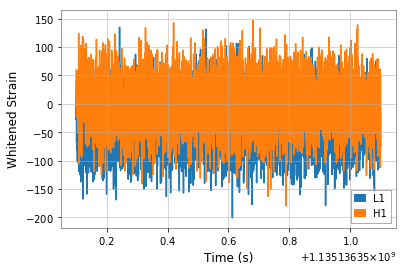

In [0]:
whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

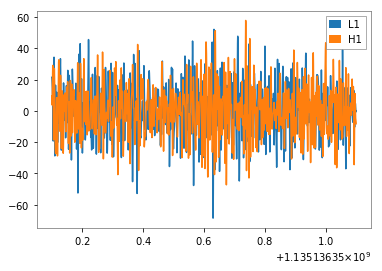

In [0]:
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

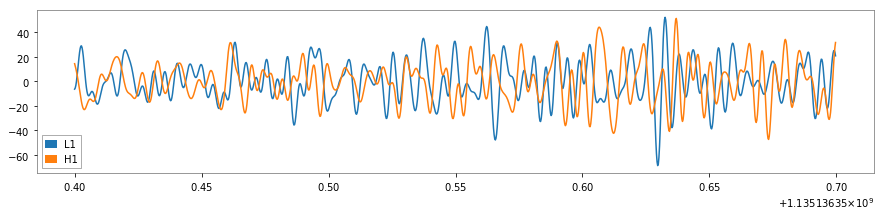

In [0]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

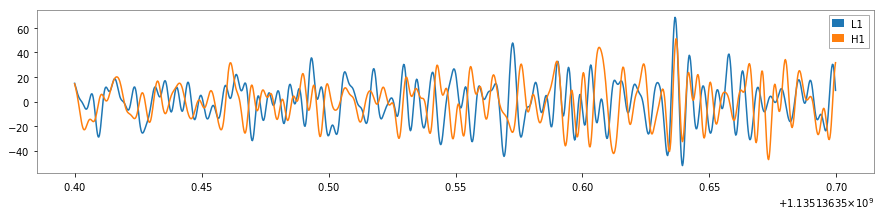

In [0]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * .007))
        bpsd *= -1
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

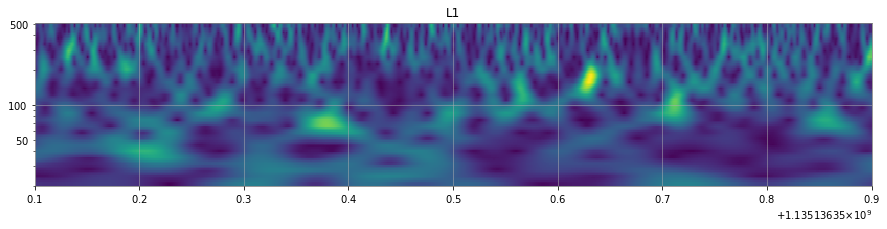

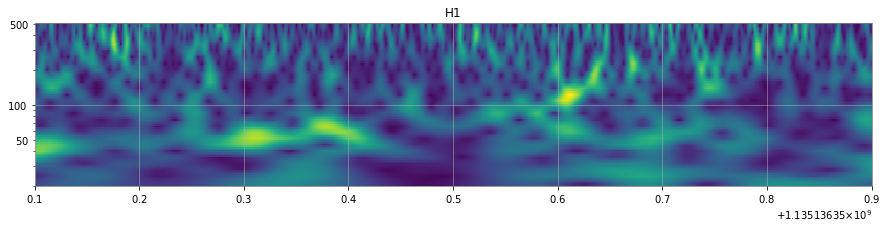

In [0]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(m.time - 5, m.time + 5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(m.time - 0.5, m.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()
    

testing for whitening

In [0]:
%matplotlib inline

# Read in the data around GW150914 //GW170104
from pycbc.catalog import Merger
import pylab

m = Merger('GW170104')
print(type(m))
data = {}

for i in ['L1','H1']:#, 'L1']:
    data[i] = m.strain(i)
    print(i)

<class 'pycbc.catalog.Merger'>
L1
H1


In [0]:
from pycbc.catalog import catalog
a=catalog.get_source('GW170104')

ValueError: ignored

# Quickview Notebook

Welcome! This IPython notebook provides a quick look at short segments of data from the <a href='https://gw-osc.org/'>Gravitational Wave Open Science Center</a>

* Set the GPS time (t0) and detector in the first cell
* Click "Run All" in the cell menu at the top
* Your plots will appear below

v0.6; August 2019

In [0]:
timeline_set=np.arange(1167559934,1167559938,1)

## SET PARAMETERS: Detector and GPS time

In [0]:
# -- Set a GPS time:
t0 = 1135136350.65    # -- GW150914

#-- Choose detector as H1, L1, or V1
detector = 'H1'

You might try some of these examples times in the H1 detector:
<pre>
t0 = 1126259462.4    # -- GW150914
t0 = 1187008882.4    # -- GW170817
t0 = 933200215       # -- Loud hardware injection
t0 = 1132401286.33   # -- Koi Fish Glitch
</pre>

### Import some packages

In [0]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q gwpy
    from gwpy.timeseries import TimeSeries   

### Query and download data file

In [0]:
from gwosc.locate import get_urls
url = get_urls(detector, t0, t0)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:                 
    straindata = requests.get(url)
    strainfile.write(straindata.content)

Downloading:  https://www.gw-osc.org/catalog/GWTC-1-confident/data/GW151226/H-H1_GWOSC_4KHZ_R1-1135134303-4096.hdf5


### Plot the raw time-series data

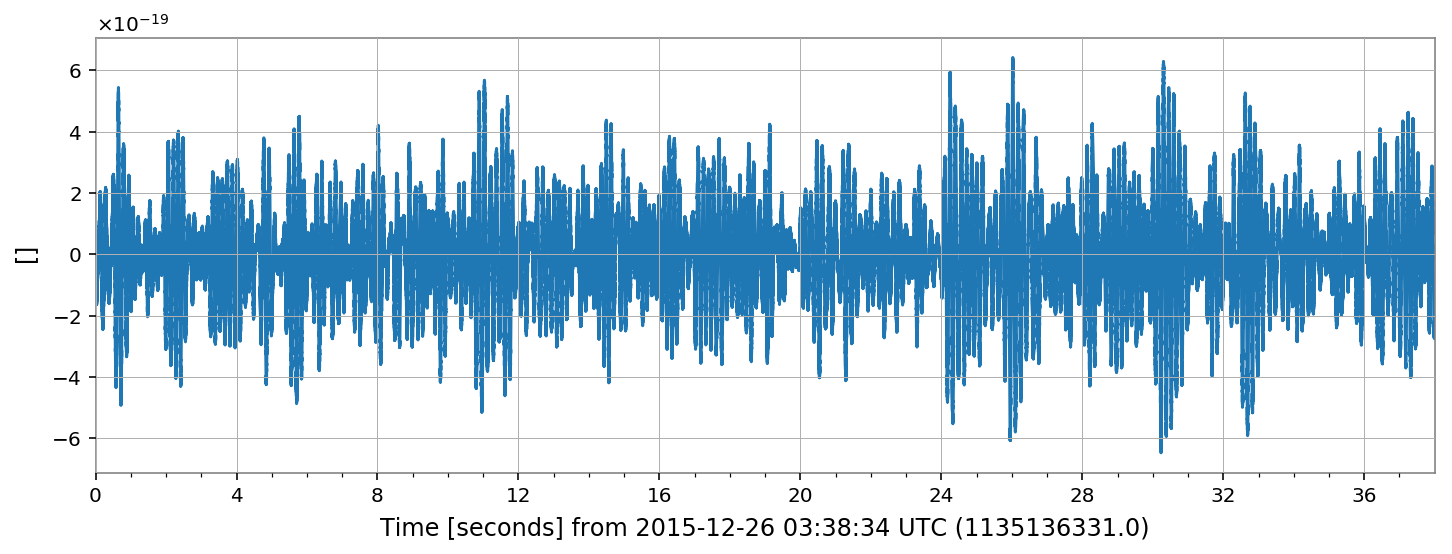

In [0]:
# -- Read strain data
strain = TimeSeries.read(fn,format='hdf5.losc')
center = int(t0)
strain = strain.crop(center-19, center+19)
fig1 = strain.plot()

### Plot the ASD

(1e-24, 1e-19)

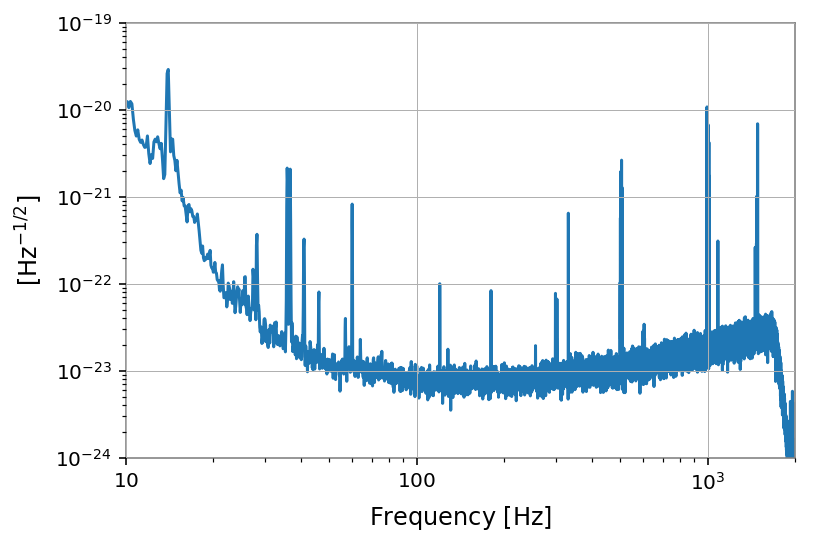

In [0]:
# -- Plot ASD
fig2 = strain.asd(fftlength=8).plot()
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)

### Whiten and band-pass the data

(1135136350.45, 1135136350.75)

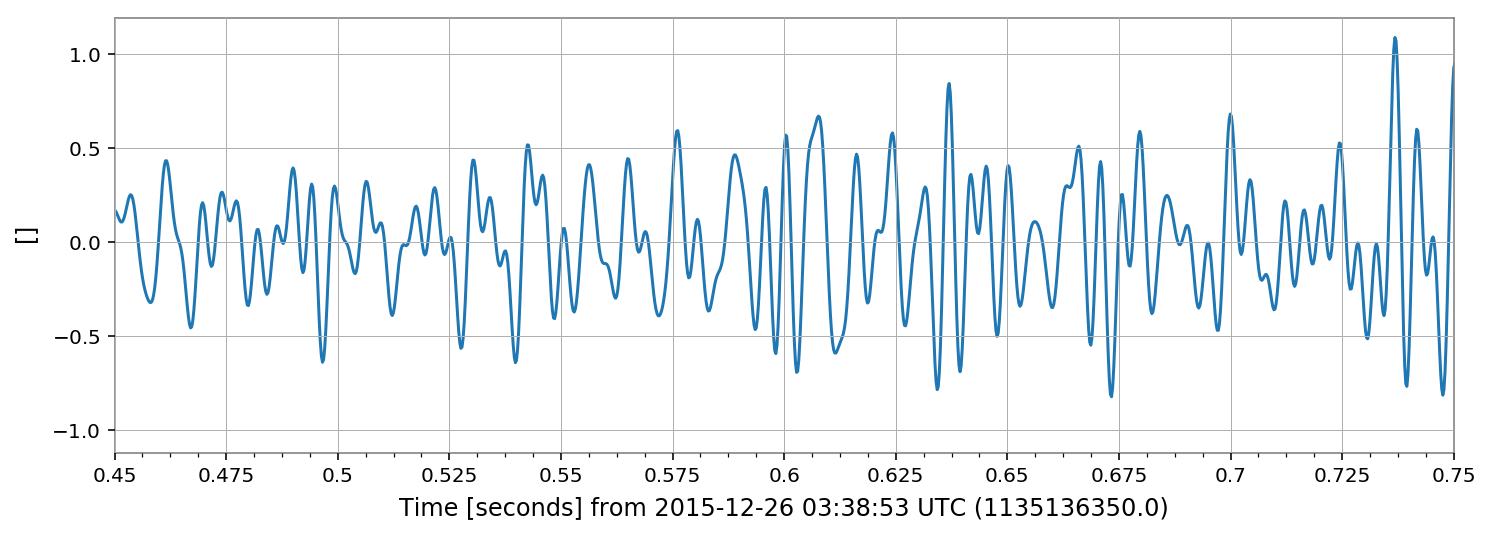

In [0]:
# -- Whiten and bandpass data
white_data = strain.whiten()
bp_data = white_data.bandpass(50,250)
notch=bp_data.notch(60)
fig3 = notch.plot()
plt.xlim(t0-0.2, t0+0.1)

# testing for final whitening

In [0]:
def figure(qty):
  fig3 = qty.plot()
  plt.xlim(t0, t0+1)
  plt.show()

In [0]:
import requests, os
import matplotlib.pyplot as plt
from gwosc.locate import get_urls
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q gwpy
    from gwpy.timeseries import TimeSeries 

In [0]:
timeline_set=np.arange(1135136350,1135136353,1)
print(timeline_set)

NameError: ignored

In [0]:
for i in range(len(timeline_set)):
  # -- Set a GPS time:
  t0 = timeline_set[i]   
  print(t0)
  #-- Choose detector as H1, L1, or V1
  detector = 'H1'

  url = get_urls(detector, t0, t0)[-1]

  #print('Downloading: ' , url)
  fn = os.path.basename(url)
  with open(fn,'wb') as strainfile:                 
      straindata = requests.get(url)
      strainfile.write(straindata.content)
      strain = TimeSeries.read(fn,format='hdf5.losc')
  #center = int(t0)
  #strain = strain.crop(center-19, center+19)
  white_data = strain.whiten()
  bp_data = white_data.bandpass(50,250)
  notch=bp_data.notch(60)
  notch2=notch.notch(120)
  figure(notch2)

NameError: ignored